# Relative Entropy Demo

---

Authors: Aaron Spring

This is a work in progress for the relative entropy method.

In [1]:
import xarray as xr
import numpy as np
import warnings
import os
warnings.filterwarnings("ignore")

In [5]:
if os.getcwd().startswith('/home/travis/'):
    mistral = False
elif (os.getcwd().startswith('/mnt/')) or (os.getcwd().startswith('/Users/aaron.spring')):
    mistral = True
else:
    mistral = False
print('on mistral:',mistral,' - should be False to test with synthetic data')

if mistral:
    from PMMPIESM.setup import _get_path
    ds = xr.open_dataset(_get_path('tos',prefix='ds')).rename({'ensemble':'init','time':'lead'})
    control = xr.open_dataset(_get_path('tos',prefix='control'))
else:
    dates = np.arange(3000, 3100)
    lats = np.arange(4)
    lons = np.arange(3)
    data = np.random.rand(len(dates), len(lats), len(lons))
    control = xr.DataArray(data,
                        coords=[dates, lats, lons],
                        dims=['time', 'lat', 'lon'])
    
    lead = np.arange(1, 4)
    lats = np.arange(4)
    lons = np.arange(3)
    member = np.arange(10)
    init = [3004, 3009, 3015, 3023]
    data = np.random.rand(len(lead), len(member), len(init), len(
        lats), len(lons))
    ds = xr.DataArray(data,
                        coords=[lead, member, init, lats, lons],
                        dims=['lead', 'member', 'init', 'lat', 'lon'])

on mistral: True  - should be False to test with synthetic data


In [40]:
from climpred.relative_entropy import compute_relative_entropy, bootstrap_relative_entropy
from climpred.graphics import plot_relative_entropy

# perfect-model

In [41]:
rel_ent = compute_relative_entropy(ds, control,nmember_control=100,neofs=8)

In [42]:
rel_ent.to_dataframe().unstack(0).head()

R                                                       \
init      3014      3023       3045      3061       3124       3139   
lead                                                                  
1     9.439726  7.529992  14.099669  9.594615  12.560448  11.762438   
2     7.586169  5.610355   7.588225  5.819408   9.346363   7.124723   
3     6.067730  6.179074   7.888868  5.055815  10.089941   5.645820   
4     6.845904  4.762418   6.736639  5.011355   8.103705   7.529008   
5     6.804760  5.645179   6.596198  3.493080   8.083344   3.350539   

                                                  ...         D            \
init       3144       3175       3178       3228  ...      3045      3061   
lead                                              ...                       
1     14.030368  10.481895  11.043364  13.891470  ...  7.510188  7.940553   
2      9.145911   6.348219   5.653792   6.419154  ...  4.851796  4.211873   
3      7.239827   6.822594   8.475466   7.863206  ...  5.827976  3.681641   
4      7.075374   6.799068   4.883215   5.675462  ...  5.158810  4.406990   
5      5.714895   3.450685   4.399707   4.977938  ...  5.014018  3.297197   

                                                                            \
init      3124      3139      3144      3175      3178      3228      3237   
lead                                                                         
1     8.362423  7.681326  6.957294  8.407985  8.312560  9.010113  7.388591   
2     4.905510  4.718035  5.038506  5.335893  4.551473  3.687683  4.279576   
3     5.037015  3.690893  4.007323  5.511400  7.817282  4.904508  5.103670   
4     4.138985  6.319827  4.956889  5.880025  4.569183  3.498433  3.457384   
5     4.597487  2.740633  4.540638  2.740756  4.083608  2.940882  3.692661   

                
init      3257  
lead            
1     6.182678  
2     5.322283  
3     3.635023  
4     5.327183  
5     4.834381  

[5 rows x 36 columns]

In [43]:
rel_ent_threshold = bootstrap_relative_entropy(ds, control, sig=50,
                               bootstrap=50, curv=True, neofs=8,
                               nmember_control=100)

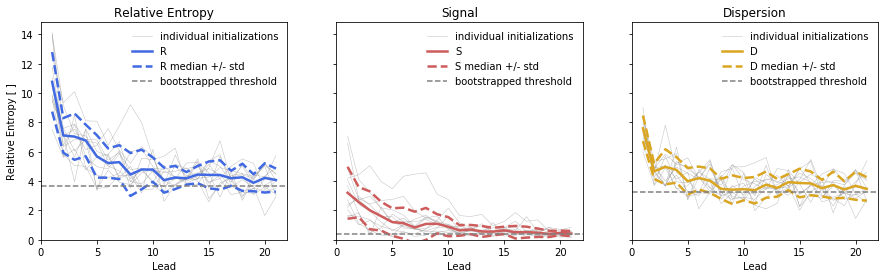

In [44]:
plot_relative_entropy(rel_ent, rel_ent_threshold=rel_ent_threshold, sharey=True, figsize=(15,4))

# DPLE, LENS
faking data with DPLE, LENS coords

In [45]:
def _shuffle(ds, dim='init'):
    """Shuffle ensemble members to uninitialize the data."""
    old_dim_range = ds[dim]
    shuffled = ds.sel({dim: np.random.permutation(ds[dim])})
    shuffled[dim] = old_dim_range
    shuffled = shuffled.sortby(dim)
    return shuffled

In [46]:
lens = xr.concat([_shuffle(control,'time') for _ in range(10)],dim='member').isel(time=slice(0,65))
lens['time']=np.arange(1950,2015)
lens['member']=np.arange(lens.member.size)
#lens

In [47]:
dple = xr.concat([lens.rename({'time':'init'})]*10,'lead')
dple['lead']=np.arange(1,1+dple.lead.size)
#dple

In [48]:
compute_relative_entropy(dple, lens,nlead=4,nmember_control=5,neofs=3).to_dataframe().unstack(0).head()

R                                                              \
init      1950      1951      1952      1953      1954      1955      1956   
lead                                                                         
1     0.821093 -0.457438  2.831244  0.693403  2.432417  0.226380  1.422948   
2     0.844242  2.716917  2.341249  0.578061  2.505471  1.513293  1.015790   
3     1.150666  0.333275  0.498749  0.767486  0.854412  1.051485  0.645340   
4     0.315004  0.470751  0.605003  0.150903  1.859842  0.505946  1.514670   

                                    ...         D                      \
init      1957      1958      1959  ...      2005      2006      2007   
lead                                ...                                 
1    -0.015451  0.458582  0.539000  ...  0.239587  0.640503  0.265728   
2     1.827866  0.290571  0.442677  ...  1.021231  0.405360  0.248043   
3     0.669014  0.625628  0.085523  ...  0.567074  0.076461  0.394741   
4     0.000000  0.526346  0.825456  ...  0.766928  0.003586 -0.109117   

                                                                            
init      2008      2009      2010      2011      2012      2013      2014  
lead                                                                        
1     0.513425  0.164017  0.557626  0.607337  0.704530 -0.095010  0.014596  
2     0.811964 -0.140970  0.169371  1.066188  0.442539  0.108447 -0.495121  
3     1.257340  0.089558  1.067052  1.022026  0.331257  0.285075  0.955896  
4     0.601087  0.446651  0.091879  1.171325  1.038657  0.977428  0.590917  

[4 rows x 195 columns]

In [49]:
bootstrap_relative_entropy(dple, lens,nlead=4,nmember_control=5,neofs=3,bootstrap=15)

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    quantile  float64 0.95
Data variables:
    R         float64 2.229
    S         float64 1.549
    D         float64 1.205

# Understand nmember_control


 nmember_control = 5


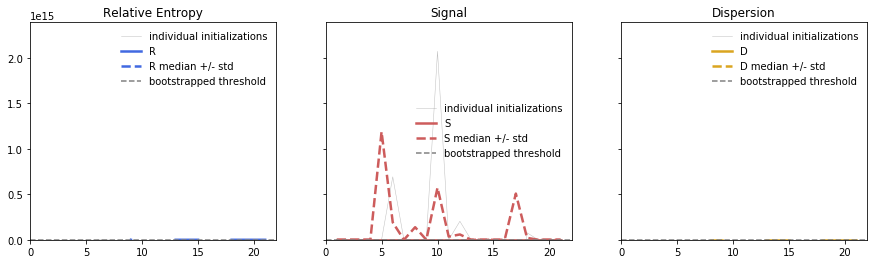


 nmember_control = 10


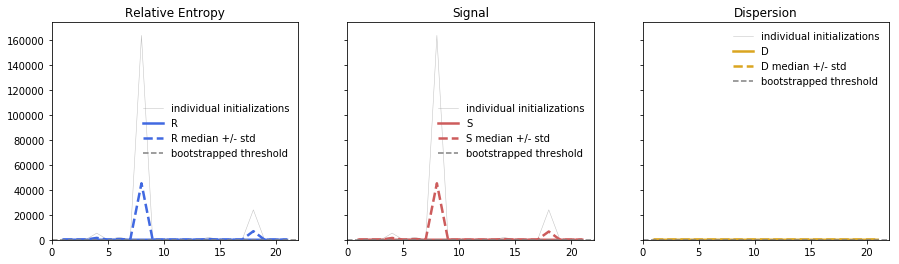


 nmember_control = 20


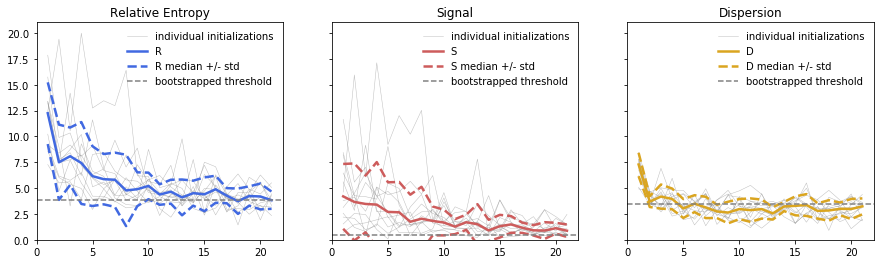


 nmember_control = 50


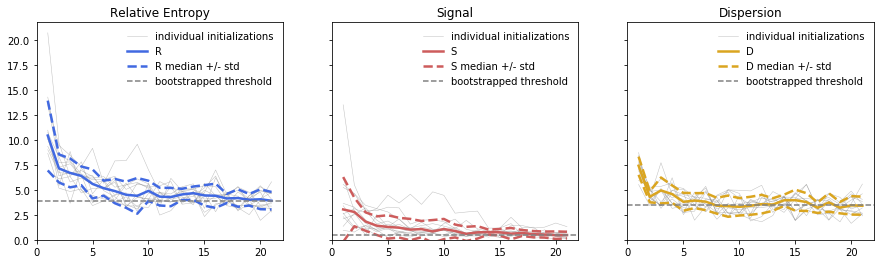


 nmember_control = 100


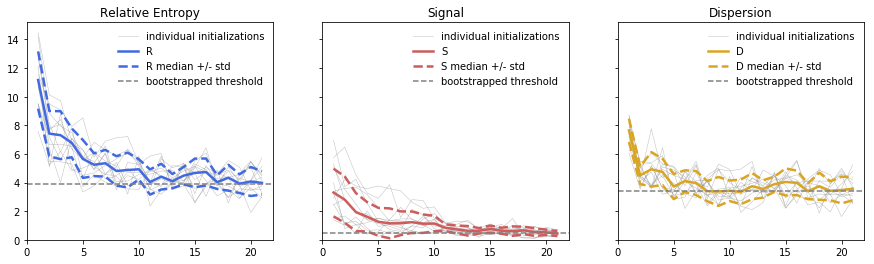

In [21]:
import matplotlib.pyplot as plt
neofs=8
for i in [5,10,20,50,100]:
    print('\n nmember_control =',i)
    rel_ent = compute_relative_entropy(ds, control,nmember_control=i,neofs=neofs)
    el_ent_threshold = bootstrap_relative_entropy(ds, control, sig=50,
                               bootstrap=50, curv=True, neofs=neofs,
                               nmember_control=i)
    plot_relative_entropy(rel_ent, rel_ent_threshold=rel_ent_threshold, sharey=True, figsize=(15,4))
    plt.show()